# Can we predict breast cancer from cell features?

# Problem
Millions of women are diagnosed with breast cancer every year. Positive diagnosis of cancer in patients is essential to mitigate harm. 

# The Data
The Data is a csv file 9 cell features (e.g. cell size) from samples taken from patients, along with whether or not that patient was diagnosed with breast cancer.

# My Solution
My solution was to implement a Support Vector Machine (SVM) to classify cells as 'Cancer' or 'Not Cancer'. An SVM is a good choice here because the EDA showed that the classes are easily separable by the features. Nonetheless, other approaches (logistic regression, random forests) are also reasonable.


# Results
Overall, I achieved an accuracy of 97%, with a recall of 93% recall and 96% precision. These results are highly accurate, however, further improvements could be made by optimizing recall (minimizing false negatives) over precision.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt 
import math
from sklearn.svm import SVC
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Read in dataset as CSV, manually putting in column headers

In [3]:
df = pd.read_csv("/home/rubisco/Desktop/wi-ml/breast-cancer-wisconsin.csv", 
                  names = ["ID", "Clump Thickness", "Cell Size Uniformity", "Cell Shape Uniformity",
                          "Marginal Adhesion", "Epithelial Size", "Bare Nuclei", "Bland Chromatin",
                          "Normal Nucleoli", "Mitoses", "Class"])

A quick visual of the data columns and first few rows

In [4]:
df.head()

,ID,Clump Thickness,Cell Size Uniformity,Cell Shape Uniformity,Marginal Adhesion,Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Types of data. It looks like all columns are integers, except Bare Nuclei

In [5]:
df.dtypes

ID                        int64
Clump Thickness           int64
Cell Size Uniformity      int64
Cell Shape Uniformity     int64
Marginal Adhesion         int64
Epithelial Size           int64
Bare Nuclei              object
Bland Chromatin           int64
Normal Nucleoli           int64
Mitoses                   int64
Class                     int64
dtype: object

Data labels associated with each column -- the Bare Nuclei column has "?"

In [6]:
features = ["Clump Thickness", "Cell Size Uniformity", "Cell Shape Uniformity",
        "Marginal Adhesion", "Epithelial Size", "Bland Chromatin", "Bare Nuclei",
        "Normal Nucleoli", "Mitoses", "Class"]
for column in features:    
    print(column, pd.Series(df[column]).unique())

Clump Thickness [ 5  3  6  4  8  1  2  7 10  9]
Cell Size Uniformity [ 1  4  8 10  2  3  7  5  6  9]
Cell Shape Uniformity [ 1  4  8 10  2  3  5  6  7  9]
Marginal Adhesion [ 1  5  3  8 10  4  6  2  9  7]
Epithelial Size [ 2  7  3  1  6  4  5  8 10  9]
Bland Chromatin [ 3  9  1  2  4  5  7  8  6 10]
Bare Nuclei ['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
Normal Nucleoli [ 1  2  7  4  5  3 10  6  9  8]
Mitoses [ 1  5  4  2  3  7 10  8  6]
Class [2 4]


We want to convert "?" elements to the averages for class 2 and 4, respectively. Calculate class averages for Bare Nuclei here

In [7]:
i = 0
Pos = 0
Pos_count = 0
Neg = 0
Neg_count = 0
Count = 0
for element in df['Bare Nuclei']:
    if element == '?':
        Count += 1
        i += 1
        continue
    if df['Class'][i] == 4:
        Pos += int(element)
        Pos_count += 1
    if df['Class'][i] == 2:
        Neg += int(element)
        Neg_count += 1
    i += 1
Neg_ave = math.floor(Neg / Neg_count)
Pos_ave = math.floor(Pos / Pos_count)


Change "?" to class averages values

In [46]:
i = 0
for element in df['Bare Nuclei']:
    if element != '?':
        df.at[i, 'Bare Nuclei'] = int(element)
    if element == '?':
        if df['Class'][i] == 2:
            df.at[i, 'Bare Nuclei'] = Neg_ave
        if df['Class'][i] == 4:
            df.at[i, 'Bare Nuclei'] = Pos_ave
    i += 1

Quick check that all data types are now integers! 

In [47]:
df['Bare Nuclei'] = df['Bare Nuclei'].astype(str).astype(int)
df.dtypes

ID                       int64
Clump Thickness          int64
Cell Size Uniformity     int64
Cell Shape Uniformity    int64
Marginal Adhesion        int64
Epithelial Size          int64
Bare Nuclei              int64
Bland Chromatin          int64
Normal Nucleoli          int64
Mitoses                  int64
Class                    int64
dtype: object

Quick look at the distribution of classes. Class 4 is represented half as much as Class 2.

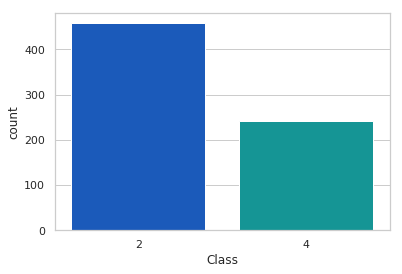

In [48]:
df['Class'].value_counts()
sns.countplot(x='Class', data=df, palette='winter');

Changing class ID's from [2,4] to [0,1]

In [49]:
df['Class']=np.where(df['Class'] ==2, 0, df['Class'])
df['Class']=np.where(df['Class'] ==4, 1, df['Class'])

Quick overview of feature means grouped by class

In [50]:
means = df.groupby(['Class']).mean()
means

,ID,Clump Thickness,Cell Size Uniformity,Cell Shape Uniformity,Marginal Adhesion,Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
Class,,,,,,,,,,
0,1.107591e+06,2.956332,1.325328,1.443231,1.364629,2.120087,1.336245,2.100437,1.290393,1.063319
1,1.003505e+06,7.195021,6.572614,6.560166,5.547718,5.298755,7.622407,5.979253,5.863071,2.589212


separating data into x and y

In [51]:
features = ["Clump Thickness", "Cell Size Uniformity", "Cell Shape Uniformity",
        "Marginal Adhesion", "Epithelial Size", "Bland Chromatin", "Bare Nuclei",
        "Normal Nucleoli", "Mitoses"]
x = df.loc[:, features].values
y = df.loc[:,['Class']].values

Distributions of each feature separated by Class. 

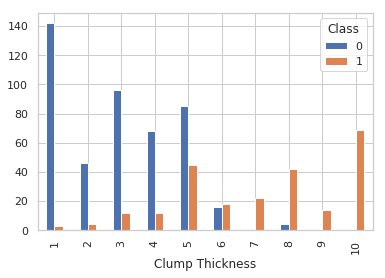

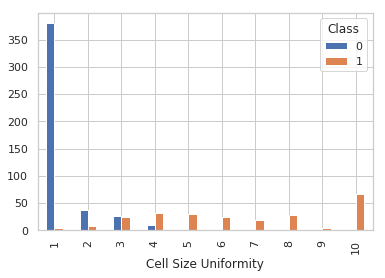

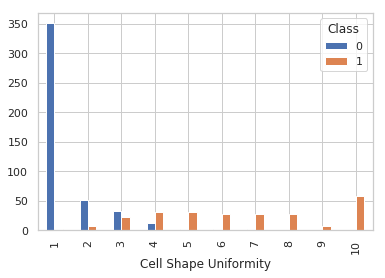

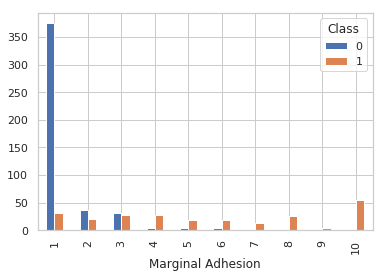

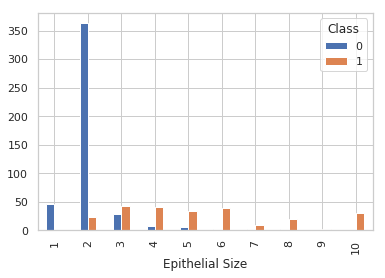

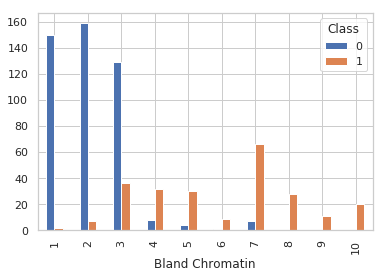

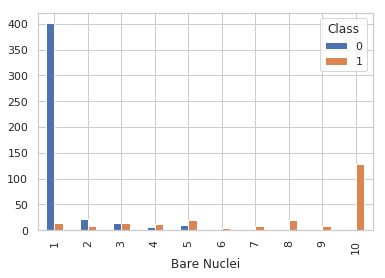

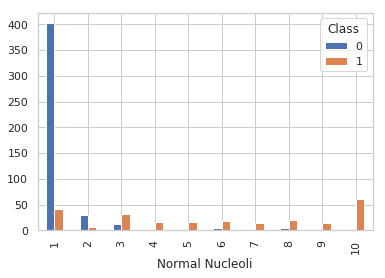

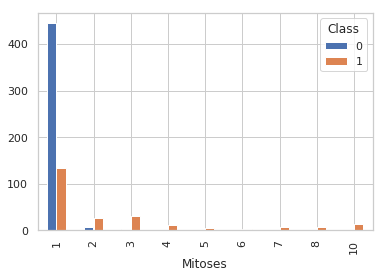

In [52]:
for element in features:
    pd.crosstab(df[element], df.Class).plot(kind='bar');

In [53]:
space = ["Clump Thickness", "Cell Size Uniformity", "Cell Shape Uniformity",
        "Marginal Adhesion", "Epithelial Size", "Bland Chromatin", "Bare Nuclei",
        "Normal Nucleoli", "Mitoses", "Class"]

In [54]:
data_vars=df.columns.values.tolist()

In [55]:
to_keep=[i for i in data_vars if i in space]
data_final=df[to_keep]

In [56]:
data_final_vars=data_final.columns.values.tolist()

Separating X and y for SVC

In [57]:
X = data_final.loc[:, data_final.columns != 'Class']
y = data_final.loc[:, data_final.columns == 'Class']

Scale data for SVC

In [58]:
from sklearn.preprocessing import scale
X = scale(X)

Separating data into train and test groups. 75% train, 25% test.

In [75]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                random_state=4002)

Specifying linear SVC model with randomized SVD fit to data

In [76]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=9, svd_solver='randomized', whiten=True).fit(Xtrain)
svc = SVC(kernel='linear',probability=True)
model = make_pipeline(pca, svc)

Grid search to find optimal C and gamma values

In [77]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [0.01, 0.1, 1, 5],
              'svc__gamma': [0.0000005, 0.000005, 0.00005, 0.0001, 0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 2.57 s, sys: 2.91 s, total: 5.49 s
Wall time: 1.5 s
{'svc__C': 0.1, 'svc__gamma': 5e-07}


Use best C and gamma values to fit from Test data

In [78]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Finding incorrect classifications! :(

In [79]:
i = 0
for element in ytest['Class']:
    if element != yfit[i]:
        print(ytest.iloc[i])
    i += 1

Class    1
Name: 12, dtype: int64
Class    0
Name: 296, dtype: int64
Class    1
Name: 51, dtype: int64
Class    1
Name: 488, dtype: int64
Class    0
Name: 1, dtype: int64
Class    1
Name: 57, dtype: int64


An example of the data where the classifier got it wrong! This example is a False Positive

In [80]:
df.iloc[259]

ID                       242970
Clump Thickness               5
Cell Size Uniformity          7
Cell Shape Uniformity         7
Marginal Adhesion             1
Epithelial Size               5
Bare Nuclei                   8
Bland Chromatin               3
Normal Nucleoli               4
Mitoses                       1
Class                         2
Name: 259, dtype: object

In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ytest, yfit)
cnf_matrix = confusion_matrix

Defining how to draw the confusion matrix

In [82]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Plot the confusion matrix

Confusion matrix, without normalization
[[116   2]
 [  4  53]]


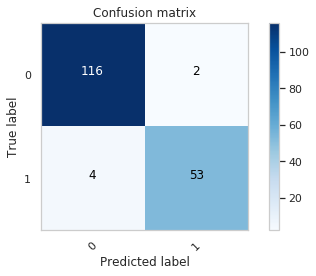

In [83]:
plt.figure()
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

Precision, recall, F1 scores

In [84]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=['1','2']))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       118
           2       0.96      0.93      0.95        57

   micro avg       0.97      0.97      0.97       175
   macro avg       0.97      0.96      0.96       175
weighted avg       0.97      0.97      0.97       175



Plot the AUC curve

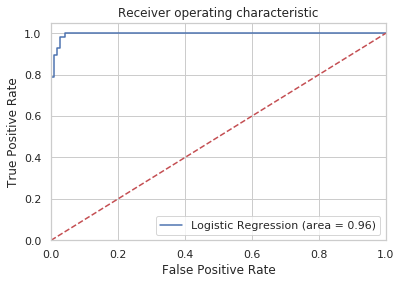

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytest, model.predict(Xtest))
fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Support Vector Machine Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()